# DonorsChoose: Donor-Project Matching with Recommender Systems
Data and project idea come from a [Kaggle compitition](https://www.kaggle.com/donorschoose/io).
Much of the recommender work is based on a [tutorial](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101/code) by [Gabriel Moreira](https://www.kaggle.com/gspmoreira).

# Donors Choose
Founded in 2000 by a Bronx history teacher, DonorsChoose.org has raised $685 million for America's classrooms. Teachers at three-quarters of all the public schools in the U.S. have come to DonorsChoose.org to request what their students need, making DonorsChoose.org the leading platform for supporting public education.

To date, 3 million people and partners have funded 1.1 million DonorsChoose.org projects. But teachers still spend more than a billion dollars of their own money on classroom materials. To get students what they need to learn, the team at DonorsChoose.org needs to be able to connect donors with the projects that most inspire them.

In the second Kaggle Data Science for Good challenge, DonorsChoose.org, in partnership with Google.org, is inviting the community to help them pair up donors to the classroom requests that will most motivate them to make an additional gift. To support this challenge, DonorsChoose.org has supplied anonymized data on donor giving from the past five years. The winning methods will be implemented in DonorsChoose.org email marketing campaigns.

# Problem Statement
DonorsChoose.org has funded over 1.1 million classroom requests through the support of 3 million donors, the majority of whom were making their first-ever donation to a public school. If DonorsChoose.org can motivate even a fraction of those donors to make another donation, that could have a huge impact on the number of classroom requests fulfilled.

A good solution will enable DonorsChoose.org to build targeted email campaigns recommending specific classroom requests to prior donors. Part of the challenge is to assess the needs of the organization, uncover insights from the data available, and build the right solution for this problem. Submissions will be evaluated on the following criteria:

Performance - How well does the solution match donors to project requests to which they would be motivated to donate? DonorsChoose.org will not be able to live test every submission, so a strong entry will clearly articulate why it will be effective at motivating repeat donations.

Adaptable - The DonorsChoose.org team wants to put the winning submissions to work, quickly. Therefore a good entry will be easy to implement in production.

Intelligible - A good entry should be easily understood by the DonorsChoose.org team should it need to be updated in the future to accommodate a changing marketplace.

# Proposed Solution

I will address the problem by using [Recommender System](https://en.wikipedia.org/wiki/Recommender_system) (RecSys) techniques. The objective of a RecSys is to recommend relevant items for users, based on their preference. Preference and relevance are subjective, and they are generally inferred by items users have consumed previously.

The main RecSys techniques are:  
   - [**Collaborative Filtering**](https://en.wikipedia.org/wiki/Collaborative_filtering): This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.   
   - [**Content-Based Filtering**](http://recommender-systems.org/content-based-filtering/): This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.  
   - **Hybrid methods**:  Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

## Load libraries

In [1]:
#enable auto complete
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib as cm
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import scipy
from scipy.sparse.linalg import svds
import math
import random
import sklearn

from numpy import array

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import os
print(os.listdir("../input"))

from sklearn import preprocessing
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")

# Print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

['Schools.csv', 'Donations.csv', 'Resources.csv', 'Donors.csv', 'Teachers.csv', 'Projects.csv']


## Load data

In [3]:
projects = pd.read_csv('../input/Projects.csv')
donations = pd.read_csv('../input/Donations.csv')
donors = pd.read_csv('Donors.csv', low_memory=False)

In [4]:
schools = pd.read_csv('../input/Schools.csv', error_bad_lines=False)
teachers = pd.read_csv('../input/Teachers.csv', error_bad_lines=False)
resources = pd.read_csv('../input/Resources.csv', error_bad_lines=False, warn_bad_lines=False)

In [5]:
print(' donations: ',donations.shape,'\n',
'donors: ',donors.shape,'\n',
'schools',schools.shape,'\n',
'teachers',teachers.shape,'\n',
'projects',teachers.shape,'\n',
'resources',resources.shape)

 donations:  (4687884, 7) 
 donors:  (2122640, 5) 
 schools (72993, 9) 
 teachers (402900, 3) 
 projects (402900, 3) 
 resources (7210448, 5)


### Set up test mode where only 10000 rows of donation/donor dataframe are used. 
When testing is complete we will need to turn off test mode.

In [6]:
# Set up test mode to save some time
test_mode = True

# Merge datasets
donations = donations.merge(donors, on="Donor ID", how="left")
df = donations.merge(projects,on="Project ID", how="left")

# only load a few lines in test mode
if test_mode:
    df = df.head(10000)

donations_df = df
print('shape of df is ',df.shape)

shape of df is  (10000, 25)


In [7]:
#df -> donors + donations
print('shape of df is ',df.shape)

shape of df is  (10000, 25)


# EDA

In [8]:
donations.head()

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57,West Jordan,Utah,No,840
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23,Riverton,Utah,Yes,840
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46,Riverton,Utah,No,840
3,000009891526c0ade7180f8423792063,38d2744bf9138b0b57ed581c76c0e2da,377944ad61f72d800b25ec1862aec363,Yes,25.00,1,2016-05-15 10:23:04,Phoenix,Arizona,No,850
4,000009891526c0ade7180f8423792063,5a032791e31167a70206bfb86fb60035,6d5b22d39e68c656071a842732c63a0c,Yes,25.00,2,2016-05-17 01:23:38,Salt Lake City,Utah,Yes,841


In [9]:
donors.head(10)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602
1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,No,245
2,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953
3,00002eb25d60a09c318efbd0797bffb5,Indianapolis,Indiana,No,462
4,0000300773fe015f870914b42528541b,Paterson,New Jersey,No,075
5,00004c31ce07c22148ee37acd0f814b9,NaN,other,No,NaN
6,00004e32a448b4832e1b993500bf0731,Stamford,Connecticut,No,069
7,00004fa20a986e60a40262ba53d7edf1,Green Bay,Wisconsin,No,543
8,00005454366b6b914f9a8290f18f4aed,Argyle,New York,No,128
9,0000584b8cdaeaa6b3de82be509db839,Valparaiso,Indiana,No,463


In [10]:
schools.head(3)

,School ID,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
0,00003e0fdd601b8ea0a6eb44057b9c5e,Capon Bridge Middle School,rural,56.0,West Virginia,26711,Capon Bridge,Hampshire,Hampshire Co School District
1,00004e32a448b4832e1b993500bf0731,The Woodlands College Park High School,urban,41.0,Texas,77384,The Woodlands,Montgomery,Conroe Ind School District
2,0002021bb799f28de224f1acc1ff08c4,Samantha Smith Elementary School,suburban,2.0,Washington,98074,Sammamish,King,Lake Washington Sch Dist 414


In [11]:
teachers.head(3)

,Teacher ID,Teacher Prefix,Teacher First Project Posted Date
0,00000f7264c27ba6fea0c837ed6aa0aa,Mrs.,2013-08-21
1,00002d44003ed46b066607c5455a999a,Mrs.,2016-10-23
2,00006084c3d92d904a22e0a70f5c119a,Mr.,2016-09-08


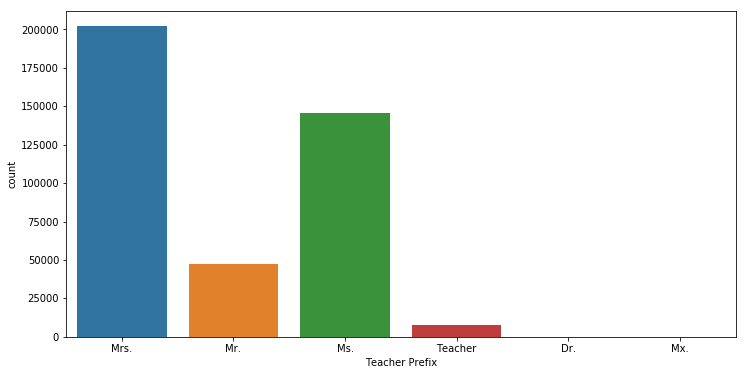

In [12]:
plt.rcParams["figure.figsize"] = [12,6]
#teachers['Teacher Prefix'].plot(kind = 'bar')
sns.countplot(x='Teacher Prefix', data=teachers);

In [13]:
projects.head(3)

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Current Status,Project Fully Funded Date
0,77b7d3f2ac4e32d538914e4a8cb8a525,c2d5cb0a29a62e72cdccee939f434181,59f7d2c62f7e76a99d31db6f62b7b67c,2,Teacher-Led,Anti-Bullying Begins with Me,do you remember your favorite classroom from e...,"Applied Learning, Literacy & Language","Character Education, Literacy",Grades PreK-2,Books,$490.38,2013-01-01,Fully Funded,2013-03-12
1,fd928b7f6386366a9cad2bea40df4b25,8acbb544c9215b25c71a0c655200baea,8fbd92394e20d647ddcdc6085ce1604b,1,Teacher-Led,Ukuleles For Middle Schoolers,what sound is happier than a ukulele? we have...,Music & The Arts,Music,Grades 6-8,Supplies,$420.61,2013-01-01,Expired,NaN
2,7c915e8e1d27f10a94abd689e99c336f,0ae85ea7c7acc41cffa9f81dc61d46df,9140ac16d2e6cee45bd50b0b2ce8cd04,2,Teacher-Led,"Big Books, Flip Books, And Everything In Between","my 1st graders may be small, but they have big...","Literacy & Language, Special Needs","Literacy, Special Needs",Grades PreK-2,Books,$510.46,2013-01-01,Fully Funded,2013-01-07


In [14]:
resources.head(3)

,Project ID,Resource Item Name,Resource Quantity,Resource Unit Price,Resource Vendor Name
0,000009891526c0ade7180f8423792063,chair move and store cart,1.0,350.00,NaN
1,00000ce845c00cbf0686c992fc369df4,sony mdr zx100 blk headphones,40.0,12.86,CDW-G
2,00002d44003ed46b066607c5455a999a,"gaiam kids stay-n-play balance ball, grey",4.0,19.00,Amazon Business


In [15]:
df.head(5)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Current Status,Project Fully Funded Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57,West Jordan,Utah,No,840,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23,Riverton,Utah,Yes,840,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46,Riverton,Utah,No,840,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23
3,000009891526c0ade7180f8423792063,38d2744bf9138b0b57ed581c76c0e2da,377944ad61f72d800b25ec1862aec363,Yes,25.00,1,2016-05-15 10:23:04,Phoenix,Arizona,No,850,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23
4,000009891526c0ade7180f8423792063,5a032791e31167a70206bfb86fb60035,6d5b22d39e68c656071a842732c63a0c,Yes,25.00,2,2016-05-17 01:23:38,Salt Lake City,Utah,Yes,841,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,Teacher-Led,OHMS Musician Chair Cart,the music students in our classes perform freq...,Music & The Arts,Music,Grades 6-8,Other,$529.68,2016-05-13,Fully Funded,2016-08-23


Donors who have donated to more than 1 campaign

In [16]:
donations_per_donor = donations.groupby('Donor ID')['Donor Cart Sequence'].max()
donations_per_donor1 = round(((donations_per_donor == 1).mean() *100),2)
print("No more than 1 donation is given by: "+ str(donations_per_donor1) +"% donors")
donations_per_donor_more_than_1 = round(((donations_per_donor > 1).mean() *100),2)
print("More than 1 donation is given by: "+ str(donations_per_donor_more_than_1) +"% donors")

No more than 1 donation is given by: 68.93% donors
More than 1 donation is given by: 31.07% donors


In [17]:
donations_per_donor = donations.groupby('Donor ID')['Donor Cart Sequence'].max()
donations_per_donor1 = round(((donations_per_donor == 1).mean() *100),2)
donations_per_donor_under_5 = (donations_per_donor < 5).mean() *100
donations_per_donor_under_10 = (donations_per_donor <10).mean() *100
donations_per_donor_under_15 = (donations_per_donor <15).mean() *100
donations_per_donor_under_20 = (donations_per_donor <20).mean() *100
donations_per_donor_under_25 = (donations_per_donor <25).mean() *100
donations_per_donor_under_30 = (donations_per_donor <30).mean() *100
donations_per_donor_over_29 = round(((donations_per_donor > 29).mean() *100),2)

between1_5=round(donations_per_donor_under_5-donations_per_donor1,2)
between5_10=round(donations_per_donor_under_10-donations_per_donor_under_5,2)
between10_15=round(donations_per_donor_under_15-donations_per_donor_under_10,2)
between15_20=round(donations_per_donor_under_20-donations_per_donor_under_15,2)
between20_25=round(donations_per_donor_under_25-donations_per_donor_under_20,2)
between25_30=round(donations_per_donor_under_30-donations_per_donor_under_25,2)

print("Only one time donation is given by: "+ str(donations_per_donor1) +"% donors")
print("2 to 4 donations are given by: "+ str(between1_5) +"% donors")
print("5 to 9 donations are given by: "+ str(between5_10) +"% donors")
print("10 to 14 donations are given by: "+ str(between10_15) +"% donors")
print("15 to 19 donations are given by: "+ str(between15_20) +"% donors")
print("20 to 24 donations are given by: "+ str(between20_25) +"% donors")
print("25 to 29 donations are given by: "+ str(between25_30) +"% donors")
print("29 or more donations are given by: "+ str(donations_per_donor_over_29) +"% donors")

Only one time donation is given by: 68.93% donors
2 to 4 donations are given by: 23.49% donors
5 to 9 donations are given by: 4.89% donors
10 to 14 donations are given by: 1.26% donors
15 to 19 donations are given by: 0.51% donors
20 to 24 donations are given by: 0.27% donors
25 to 29 donations are given by: 0.16% donors
29 or more donations are given by: 0.48% donors


In [18]:
total=donations_per_donor1+between1_5+between5_10+between10_15+between15_20+between20_25+between25_30+donations_per_donor_over_29

print('Percentages added together: '+ str(total)+'%')

Percentages added together: 99.99%


In [19]:
donations_per_donor_under_10 = (donations_per_donor <10).mean() *100
donations_per_donor_over_9=round((donations_per_donor-donations_per_donor_under_10),2)
print("10 or more donations are given by "+str(donations_per_donor_over_9)+"% donors")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Before modeling, we need to measure the relation strength between a donor and a project. Although most donors only donate once in the dataset, there are donors who donated to the same project multiple times, and users who donated to multiple projects. The donation amount also varies. To better measure this strength, we combine the times and amounts of donations, and create a new dataset containing unique donation relations between a donor, a project, and the relation strength. he number of projects and unique donor-project donation events:

In [20]:
# Deal with missing values
donations["Donation Amount"] = donations["Donation Amount"].fillna(0)

# Define event strength as the donated amount to a certain project
donations_df['eventStrength'] = donations_df['Donation Amount']

def smooth_donor_preference(x):
    return math.log(1+x, 2)
    
donations_full_df = donations_df \
                    .groupby(['Donor ID', 'Project ID'])['eventStrength'].sum() \
                    .apply(smooth_donor_preference).reset_index()
        
# Update projects dataset
project_cols = projects.columns
projects = df[project_cols].drop_duplicates()

print('# of projects: %d' % len(projects))
print('# of unique user/project donations: %d' % len(donations_full_df))

# of projects: 1889
# of unique user/project donations: 8648


Apparently, our test mode with 10000 donation events contains 1889 projects and 8648 unique user-project donations. We can also take a look at the first five rows of our donor-project dataset:

### Set up Test/Train sets

In [21]:
donations_train_df, donations_test_df = train_test_split(donations_full_df,
                                   test_size=0.20,
                                   random_state=42)

print('# donations on Train set: %d' % len(donations_train_df))
print('# donations on Test set: %d' % len(donations_test_df))

#Indexing by Donor Id to speed up the searches during evaluation
donations_full_indexed_df = donations_full_df.set_index('Donor ID')
donations_train_indexed_df = donations_train_df.set_index('Donor ID')
donations_test_indexed_df = donations_test_df.set_index('Donor ID')

# donations on Train set: 6918
# donations on Test set: 1730


## 1. Content-Based Filtering model
We will use Content-Based Filtering method to find projects that are similar to the project(s) that a donor has already donated to. We can calculate the similarity between projects based on data and/or text features extracted from the text data.

I used [a tutortial by](https://www.kaggle.com/gunnvant/building-content-recommender-tutorial/notebook) user [gunnvant](https://www.kaggle.com/gunnvant) to construct word vectors with TF-IDF.

In [22]:
# Preprocessing of text data
textfeats = ["Project Title","Project Essay"]
for cols in textfeats:
    projects[cols] = projects[cols].astype(str) 
    projects[cols] = projects[cols].astype(str).fillna('') # FILL NA
    projects[cols] = projects[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
 
text = projects["Project Title"] + ' ' + projects["Project Essay"]
vectorizer = TfidfVectorizer(strip_accents='unicode',
                             analyzer='word',
                             lowercase=True, # Convert all uppercase to lowercase
                             stop_words='english', # Remove commonly found english words ('it', 'a', 'the') which do not typically contain much signal
                             max_df = 0.9, # Only consider words that appear in fewer than max_df percent of all documents
                             # max_features=5000 # Maximum features to be extracted                    
                            )                        
project_ids = projects['Project ID'].tolist()
tfidf_matrix = vectorizer.fit_transform(text)
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<1889x12490 sparse matrix of type '<class 'numpy.float64'>'
	with 182757 stored elements in Compressed Sparse Row format>

### Donor profile

In [23]:
def get_project_profile(project_id):
    idx = project_ids.index(project_id)
    project_profile = tfidf_matrix[idx:idx+1]
    return project_profile

def get_project_profiles(ids):
    project_profiles_list = [get_project_profile(x) for x in np.ravel([ids])]
    project_profiles = scipy.sparse.vstack(project_profiles_list)
    return project_profiles

def build_donors_profile(donor_id, donations_indexed_df):
    donations_donor_df = donations_indexed_df.loc[donor_id]
    donor_project_profiles = get_project_profiles(donations_donor_df['Project ID'])
    donor_project_strengths = np.array(donations_donor_df['eventStrength']).reshape(-1,1)
    #Weighted average of project profiles by the donations strength
    donor_project_strengths_weighted_avg = np.sum(donor_project_profiles.multiply(donor_project_strengths), axis=0) / (np.sum(donor_project_strengths)+1)
    donor_profile_norm = sklearn.preprocessing.normalize(donor_project_strengths_weighted_avg)
    return donor_profile_norm

from tqdm import tqdm

def build_donors_profiles(): 
    donations_indexed_df = donations_full_df[donations_full_df['Project ID'].isin(projects['Project ID'])].set_index('Donor ID')
    donor_profiles = {}
    for donor_id in tqdm(donations_indexed_df.index.unique()):
        donor_profiles[donor_id] = build_donors_profile(donor_id, donations_indexed_df)
    return donor_profiles

donor_profiles = build_donors_profiles()
print("# of donors with profiles: %d" % len(donor_profiles))

100%|██████████| 8015/8015 [00:08<00:00, 948.57it/s] 

# of donors with profiles: 8015


In [24]:
donations_full_indexed_df.head(10)

,Project ID,eventStrength
Donor ID,,
0003aba06ccf49f8c44fc2dd3b582411,0081553d51ed5d2529e2e38b0827133a,5.672425
000f7306e8ddb36296f0d97a34d67d76,007e2a1a47ce50ded4538692d0bf601b,4.700440
00125f251b05d9e447a5448bef981028,0055c89fe4b1085db791edeb67ace2e0,4.700440
0013dfb2a873420fe6e7d750ef24ce98,004baba788df541cc469c0f4f21493d6,3.087463
0016b23800f7ea46424b3254f016007a,004c7c5e1a8cbce0ee63d14574096aeb,5.672425
00199e3565635f8a5ebefd3b5985a7f3,006a17f2eff0c3dae79630c295e2a666,7.838069
00309a47b765e12714d817ee3215de1e,006a366c97f485d4f349fad018d95f42,4.075533
0036448e416b71ab040182c428958b6f,000c43686474a41cbd1b04110149160c,4.700440
00393e12bc4f2eefa1a342a83559c2be,006a366c97f485d4f349fad018d95f42,5.672425


In [25]:
donor1 = "0003aba06ccf49f8c44fc2dd3b582411"
donor2 = "0016b23800f7ea46424b3254f016007a"
donor3 = "00125f251b05d9e447a5448bef981028"
donor4 = "0013dfb2a873420fe6e7d750ef24ce98"
donor5 = "0016b23800f7ea46424b3254f016007a"
donor6 = "00199e3565635f8a5ebefd3b5985a7f3"
donor7 = "00309a47b765e12714d817ee3215de1e"
donor8 = "0036448e416b71ab040182c428958b6f"
donor9 = "00393e12bc4f2eefa1a342a83559c2be"
donor10 = "0052dd04a7cf2d91db791c94dec448ac"
donor1_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor1].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token1', 'relevance1'])
donor2_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor2].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token2', 'relevance2'])
donor3_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor3].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token3', 'relevance3'])
donor4_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor4].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token4', 'relevance4'])
donor5_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor5].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token5', 'relevance5'])
donor6_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor6].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token6', 'relevance6'])
donor7_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor7].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token7', 'relevance7'])
donor8_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor8].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token8', 'relevance8'])
donor9_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor9].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token9', 'relevance9'])
donor10_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        donor_profiles[donor10].flatten().tolist()), 
                        key=lambda x: -x[1])[:10],
                        columns=['token10', 'relevance10'])


In [26]:
example_profiles = donor1_profile.join(donor2_profile)
example_profiles = example_profiles.join(donor3_profile)
example_profiles = example_profiles.join(donor4_profile)
example_profiles = example_profiles.join(donor6_profile)
example_profiles = example_profiles.join(donor7_profile)
example_profiles = example_profiles.join(donor8_profile)
example_profiles = example_profiles.join(donor9_profile)
example_profiles = example_profiles.join(donor10_profile)

In [27]:
example_profiles.head(10)

,token1,relevance1,token2,relevance2,token3,relevance3,token4,relevance4,token6,relevance6,token7,relevance7,token8,relevance8,token9,relevance9,token10,relevance10
0,sets,0.313237,pollinators,0.672316,castles,0.322847,computers,0.342839,brockton,0.318679,pinocchio,0.515412,cubbies,0.595062,pinocchio,0.515412,diary,0.440622
1,reading,0.286720,plants,0.306352,ed,0.259267,technology,0.293033,play,0.268543,conversations,0.264213,coat,0.228447,conversations,0.264213,freedom,0.248476
2,zoom,0.283351,module,0.224105,frames,0.253062,computer,0.246495,kits,0.214771,engage,0.217155,belong,0.185914,engage,0.217155,writers,0.224292
3,levels,0.232165,pollination,0.212532,art,0.224827,complete,0.186191,challenged,0.189753,limited,0.208959,guessing,0.160592,limited,0.208959,8th,0.209120
4,books,0.213696,seeds,0.181173,love,0.200784,laptop,0.182040,bonded,0.168017,experiences,0.197402,mittens,0.160592,experiences,0.197402,literature,0.187446
5,running,0.186840,writing,0.164691,create,0.199808,research,0.175615,dates,0.168017,experience,0.166451,personal,0.156511,experience,0.166451,weapons,0.185847
6,advance,0.185617,books,0.135212,picture,0.199157,presentations,0.174949,ita,0.168017,performance,0.158564,independent,0.147382,performance,0.158564,30,0.153560
7,groups,0.173083,reading,0.113385,writing,0.187631,lessons,0.171142,backyards,0.148408,live,0.154904,items,0.141920,live,0.154904,reflects,0.153031
8,order,0.163861,weaved,0.112053,express,0.181023,use,0.150782,coaches,0.148408,play,0.154460,hats,0.141850,play,0.154460,classic,0.128033
9,book,0.158681,bees,0.102160,inspire,0.172123,working,0.134765,active,0.145138,draw,0.150138,born,0.118058,draw,0.150138,obstacles,0.118095
